<a href="https://colab.research.google.com/github/tcapelle/solar_seg/blob/master/Solar_Images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import fastai
from fastai.vision import *

In [4]:
from fastai.utils.show_install import *
show_install()



```text
=== Software === 
python        : 3.6.7
fastai        : 1.0.42
fastprogress  : 0.1.18
torch         : 1.0.0
nvidia driver : 396.44
torch cuda    : 9.0.176 / is available
torch cudnn   : 7401 / is enabled

=== Hardware === 
nvidia gpus   : 1
torch devices : 1
  - gpu0      : 11441MB | Tesla K80

=== Environment === 
platform      : Linux-4.14.79+-x86_64-with-Ubuntu-18.04-bionic
distro        : #1 SMP Wed Dec 19 21:19:13 PST 2018
conda env     : Unknown
python        : /usr/bin/python3
sys.path      : 
/env/python
/usr/lib/python36.zip
/usr/lib/python3.6
/usr/lib/python3.6/lib-dynload
/usr/local/lib/python3.6/dist-packages
/usr/lib/python3/dist-packages
/usr/local/lib/python3.6/dist-packages/IPython/extensions
/root/.ipython
```

Please make sure to include opening/closing ``` when you paste into forums/github to make the reports appear formatted as code sections.

Optional package(s) to enhance the diagnostics can be installed with:
pip install distro
Once installed, re-run th

In [5]:
!git clone https://github.com/tcapelle/solar_seg/

fatal: destination path 'solar_seg' already exists and is not an empty directory.


In [0]:
path = Path('solar_seg/')
path_lbl = path/'masks'
path_img = path/'images'

In [7]:
fnames = get_image_files(path_img)
fnames[:3]

[PosixPath('solar_seg/images/02920.png'),
 PosixPath('solar_seg/images/00659.png'),
 PosixPath('solar_seg/images/00710.png')]

In [8]:
lbl_names = get_image_files(path_lbl)
lbl_names[:3]

[PosixPath('solar_seg/masks/02920.png'),
 PosixPath('solar_seg/masks/00659.png'),
 PosixPath('solar_seg/masks/00710.png')]

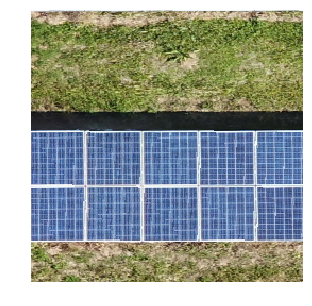

In [9]:
img_f = fnames[115]
img = open_image(img_f)
img.show(figsize=(5,5))

In [0]:
get_y_fn = lambda x: path_lbl/f'{x.stem}{x.suffix}'

In [11]:
get_y_fn(img_f)

PosixPath('solar_seg/masks/01117.png')

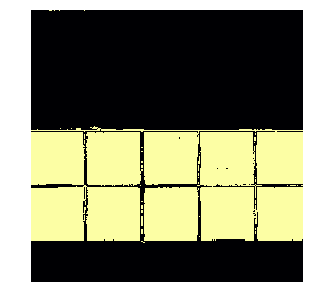

In [63]:
mask = open_mask(get_y_fn(img_f), div=True)
mask.show(figsize=(5,5), alpha=1, cmap = 'inferno')

In [64]:
src_size = np.array(mask.shape[1:])
src_size,mask.data

(array([256, 256]), tensor([[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]]]))

In [0]:
size = src_size//2
bs=64

In [0]:
class MySegmentationLabelList(SegmentationLabelList):
  def open(self, fn): return open_mask(fn, div=True)

class MySegmentationItemList(ImageItemList):
    "`ItemList` suitable for segmentation tasks."
    _label_cls,_square_show_res = MySegmentationLabelList,False

In [0]:
def get_data(sz, bs):
  src = (MySegmentationItemList.from_folder(path_img)
       .random_split_by_pct(.2)
       .label_from_func(get_y_fn, classes=['background','solar_module']))
  data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))
  return data

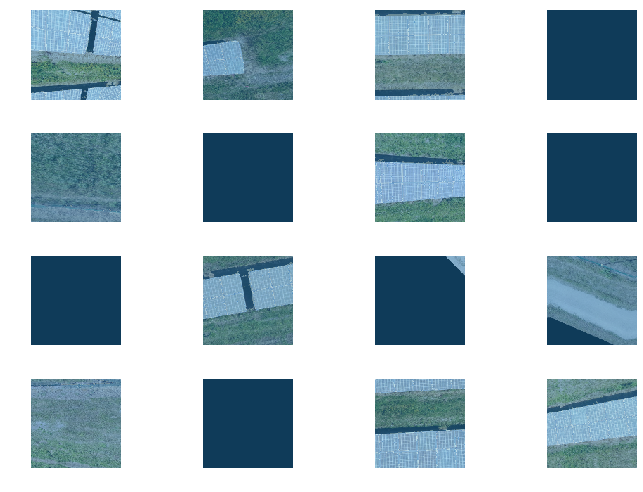

In [85]:
data = get_data(128, 64)
data.show_batch(4, figsize=(10,7), cmap='inferno')

In [0]:
metrics = partial(dice, iou=True)
wd = 1e-2

In [0]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


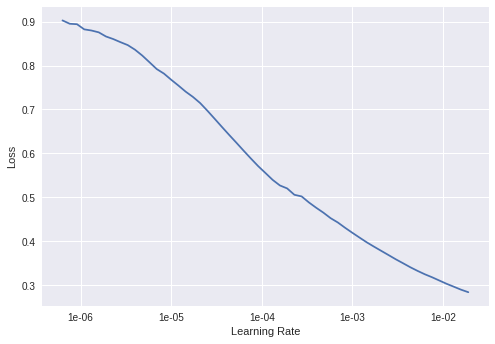

In [38]:
learn.lr_find(); learn.recorder.plot()

In [39]:
learn.fit_one_cycle(6, 1e-3)

epoch,train_loss,valid_loss,dice
1,0.104332,0.035138,0.918151
2,0.053056,0.028197,0.933369
3,0.036618,0.025110,0.941446
4,0.028618,0.021728,0.946542
5,0.025476,0.022210,0.947372
6,0.023491,0.021112,0.948264


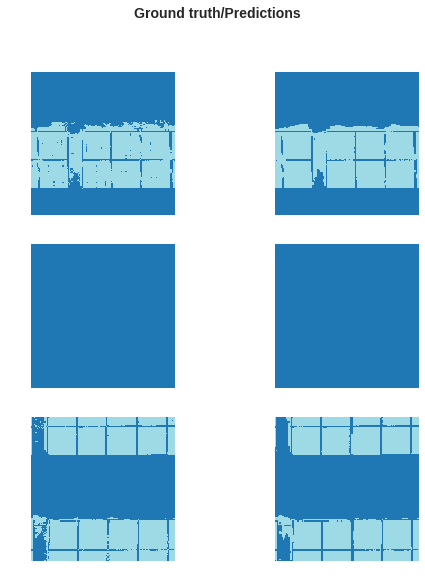

In [83]:
learn.show_results(rows=3, figsize=(8,9), alpha=1)

In [0]:
learn.data = get_data(256, 16)

In [0]:
learn.fit_one_cycle(3, 1e-4)

epoch,train_loss,valid_loss,dice
